In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import the libraries that we need for this project.
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from xgboost import plot_tree

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [5]:
# Load the training dataset
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
# Check the data types of the columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
# How many values are we missing?
train_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
# Let's see if anyone that was reported as sleeping spent any money on ships services.
sleeping = train_df[train_df['CryoSleep'] == True]
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    print(sleeping[col].value_counts())
    print()

RoomService
0.0    2969
Name: count, dtype: int64

FoodCourt
0.0    2967
Name: count, dtype: int64

ShoppingMall
0.0    2941
Name: count, dtype: int64

Spa
0.0    2972
Name: count, dtype: int64

VRDeck
0.0    2975
Name: count, dtype: int64



In [9]:
train_df['VIP'].value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

In [10]:
class DistributionImputer(BaseEstimator, TransformerMixin):
    """An imputer that fills missing values with a random sample from a given distribution.
    """

    def __init__(self, columns):
        self.columns = columns
        self.distributions = {}

    def fit(self, X, y=None):
        for column in self.columns:
            self.distributions[column] = X[column].dropna().value_counts(normalize=True)

        return self

    def transform(self, X):
        X = X.copy()
        for column in self.columns:
            missing = X[column].isna()
            X.loc[missing, column] = np.random.choice(self.distributions[column].index, size=len(X[missing]), p=self.distributions[column].values)

        return X

In [11]:
class BooleanImputer(BaseEstimator, TransformerMixin):
    """An imputer that fills `target_column` with a boolean value based non-zero values in any of the `source_columns`.
    """

    def __init__(self, source_columns, target_column, invert=False):
        self.source_columns = source_columns
        self.target_column = target_column
        self.invert = invert

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        any_not_zero = X[self.source_columns].any(axis=1)
        if self.invert:
            any_not_zero = ~any_not_zero
        X[self.target_column] = any_not_zero
        X[self.target_column] = X[self.target_column].astype(bool)

        return X

In [12]:
class ColumnSplitEncoder(BaseEstimator, TransformerMixin):
    """
    An encoder that splits a `str` `source_column` into `n` columns based on a `separator`.
    Result columns are named based upon the `dest_columns` and the index of the split.
    """

    def __init__(self, source_column, dest_columns, separator):
        self.source_column = source_column
        self.dest_columns = dest_columns
        self.separator = separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.dest_columns] = X[self.source_column].str.split(self.separator, expand=True)

        return X

In [13]:
class ConstantImputer(BaseEstimator, TransformerMixin):
    """
    An imputer that fills `target_columns` that are missing values with a `constant` value.
    """

    def __init__(self, target_columns, constant):
        self.target_columns = target_columns
        self.constant = constant

        if isinstance(constant, bool):
            self.constant = 1 if constant else 0
            self.boolean = True
        else:
            self.boolean = False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.target_columns] = X[self.target_columns].fillna(self.constant)
        X[self.target_columns] = X[self.target_columns].astype(type(self.constant))

        if self.boolean:
            X[self.target_columns] = X[self.target_columns].astype(bool)

        return X

In [14]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    A transformer that drops the `columns` from the DataFrame.
    """

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.columns)

        return X

In [15]:
class DummyColumnEncoder(BaseEstimator, TransformerMixin):
    """
    A transformer that one-hot encodes the `columns` in the DataFrame.
    """

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = pd.get_dummies(X, columns=self.columns)

        return X

In [16]:
class SumFeatureCreator(BaseEstimator, TransformerMixin):
    """
    A transformer that creates a new column `target_column` that is the sum of the `source_columns`.
    """

    def __init__(self, source_columns, target_column):
        self.source_columns = source_columns
        self.target_column = target_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.target_column] = X[self.source_columns].sum(axis=1)

        return X

In [17]:
# It makes sense to split the 'Cabin' column into 'Deck', 'Room', and 'Side' columns so that we can use them in the model.
# It makes sense to impute different things for some of the missing data:
#   * For the spending columns ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'), it makes sense to impute 0. This is the future and even today, almost no one uses cash.
#   * For the 'CryoSleep', if the value is missing, we might be able to infer from the spending if they were active on the ship. We might also be able to infer from the 'Cabin'.
#   * For 'VIP', we could take the strategy that if they were important, the data might not be missing (though to be fair, the data is corrupted). We could also infer from 'Cabin' and 'Spend'.
#   * For 'Age', 'Destination', 'HomePlanet', we could impute a random value from the distribution of the data.

pipeline = Pipeline([
    ('column_split_encoder', ColumnSplitEncoder(source_column='Cabin', dest_columns=['Deck', 'Room', 'Side'], separator='/')),
    ('unknown_room_imputer', ConstantImputer(target_columns=['Room'], constant=-1.0)),
    ('zero_imputer', ConstantImputer(target_columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], constant=0.0)),
    ('false_imputer', ConstantImputer(target_columns=['VIP'], constant=False)),
    ('boolean_imputer', BooleanImputer(source_columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], target_column='CryoSleep', invert=True)),
    ('distribution_imputer', DistributionImputer(columns=['Age', 'Destination', 'HomePlanet'])),
    ('dummy_column_encoder', DummyColumnEncoder(columns=['Destination', 'HomePlanet', 'Deck', 'Side'])),
    ('column_dropper', ColumnDropper(columns=['Cabin', 'Name', 'PassengerId']))
])

In [18]:
cleaned_train_df = pipeline.fit_transform(train_df)

In [19]:
cleaned_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   bool   
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   bool   
 9   Room                       8693 non-null   float64
 10  Destination_55 Cancri e    8693 non-null   bool   
 11  Destination_PSO J318.5-22  8693 non-null   bool   
 12  Destination_TRAPPIST-1e    8693 non-null   bool   
 13  HomePlanet_Earth           8693 non-null   bool 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

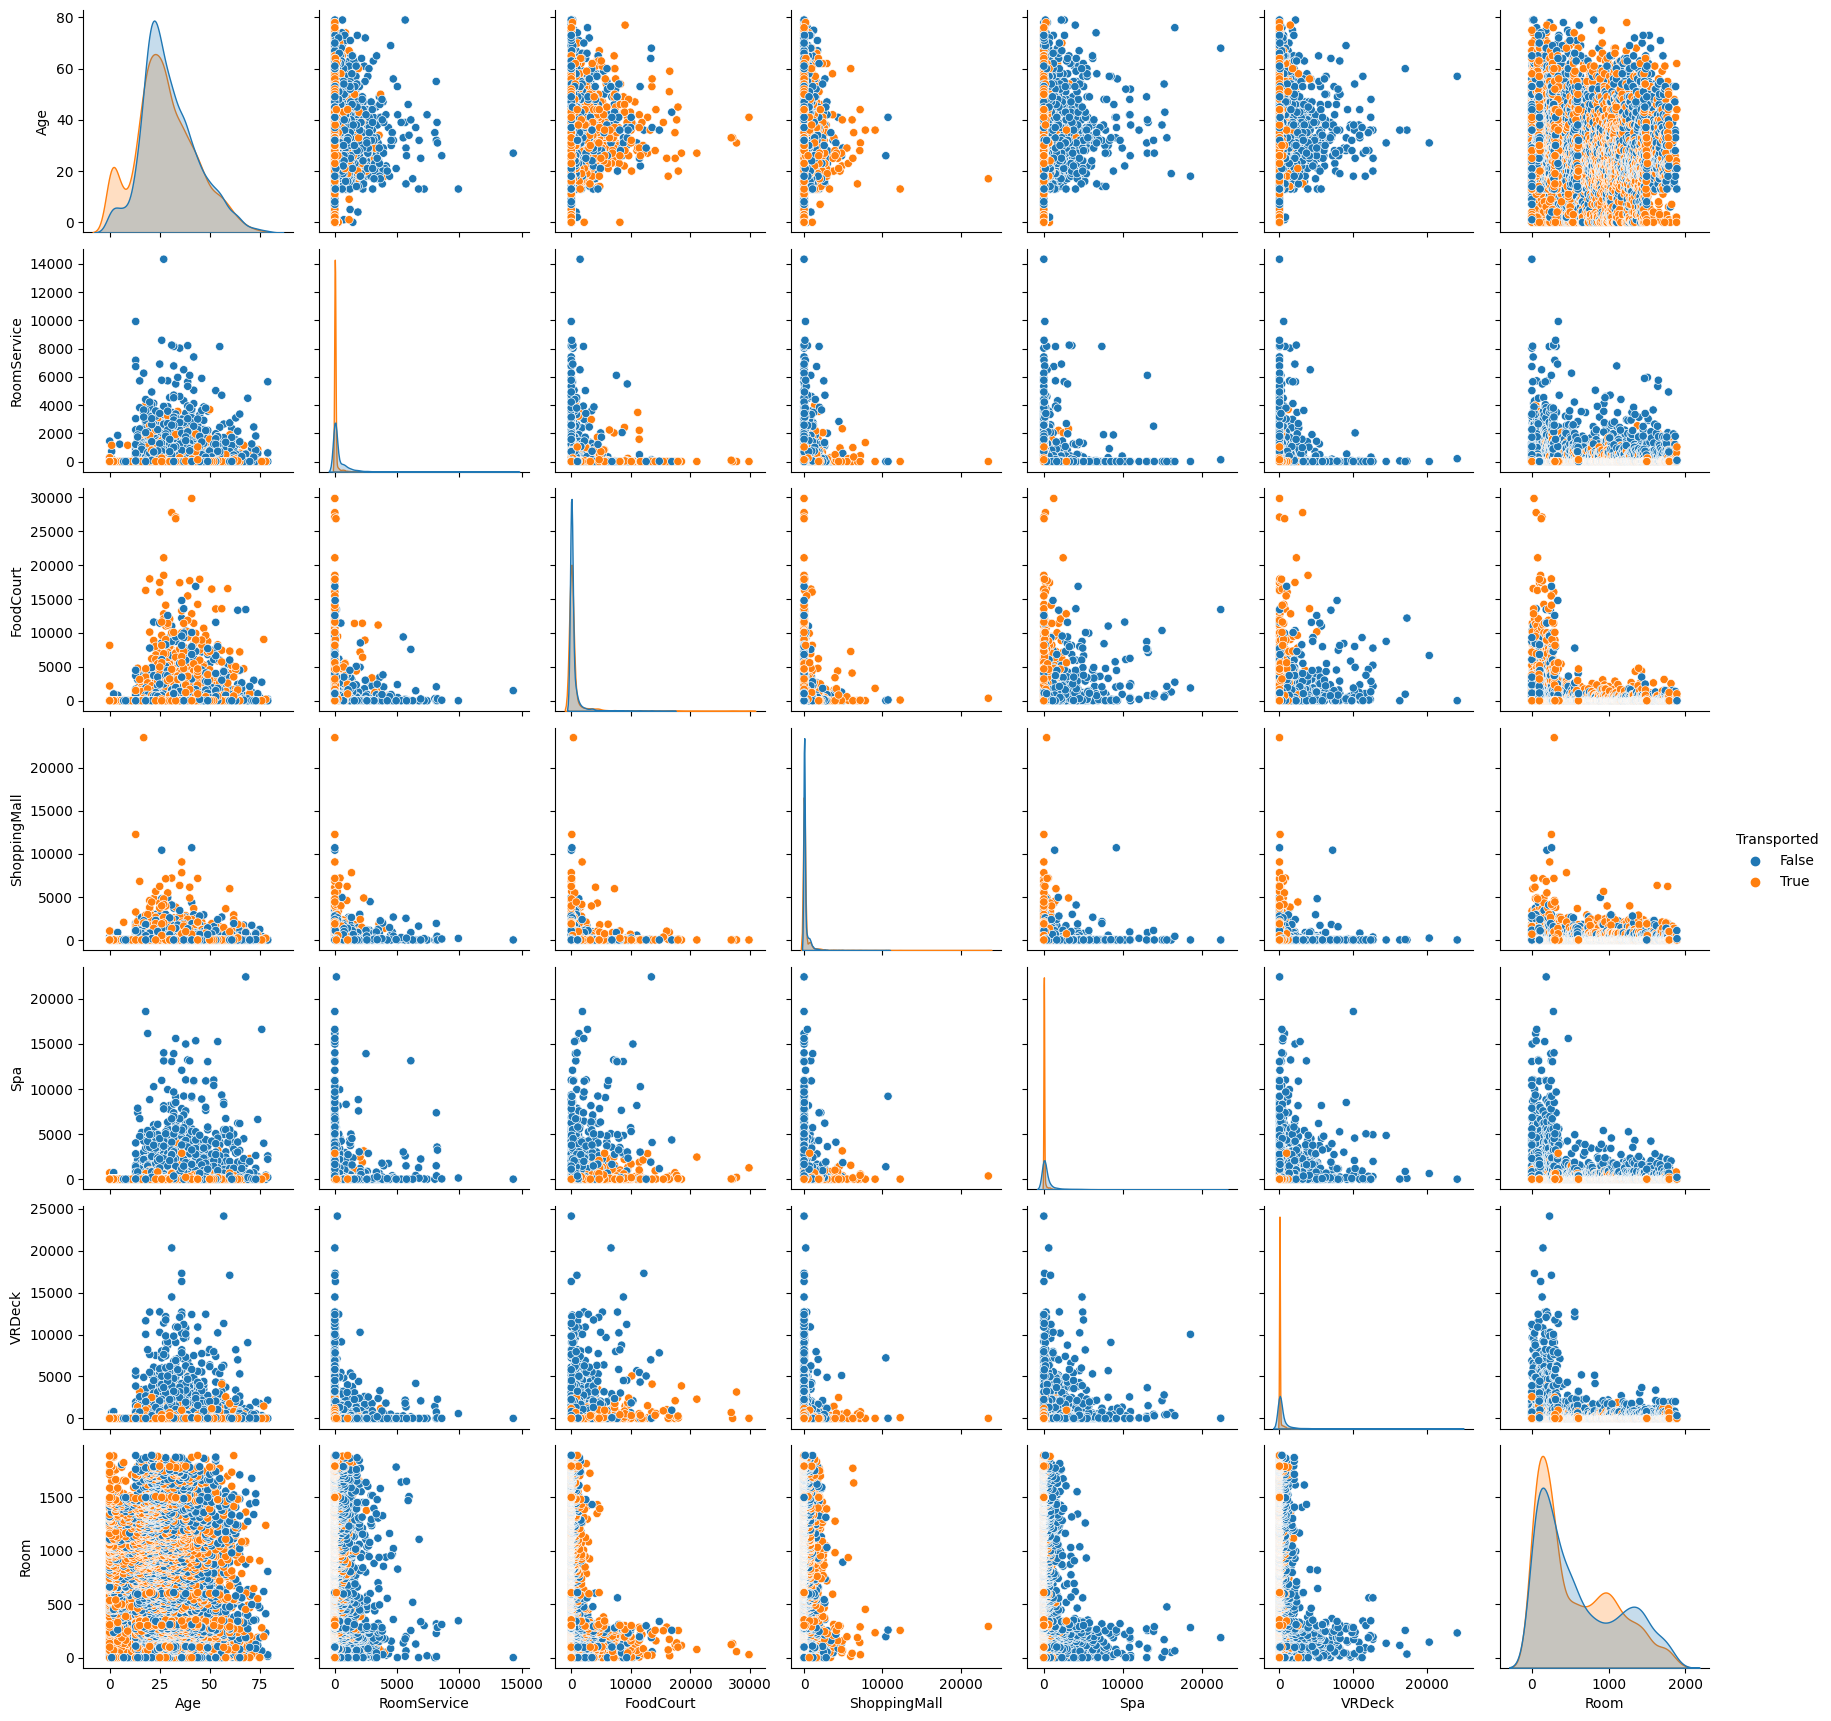

In [20]:
pair_plot_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Room', 'Transported']

sns.pairplot(cleaned_train_df[pair_plot_cols], hue='Transported', diag_kind='kde')

plt.show()

In [21]:
cleaned_train_df.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Room', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S'],
      dtype='object')

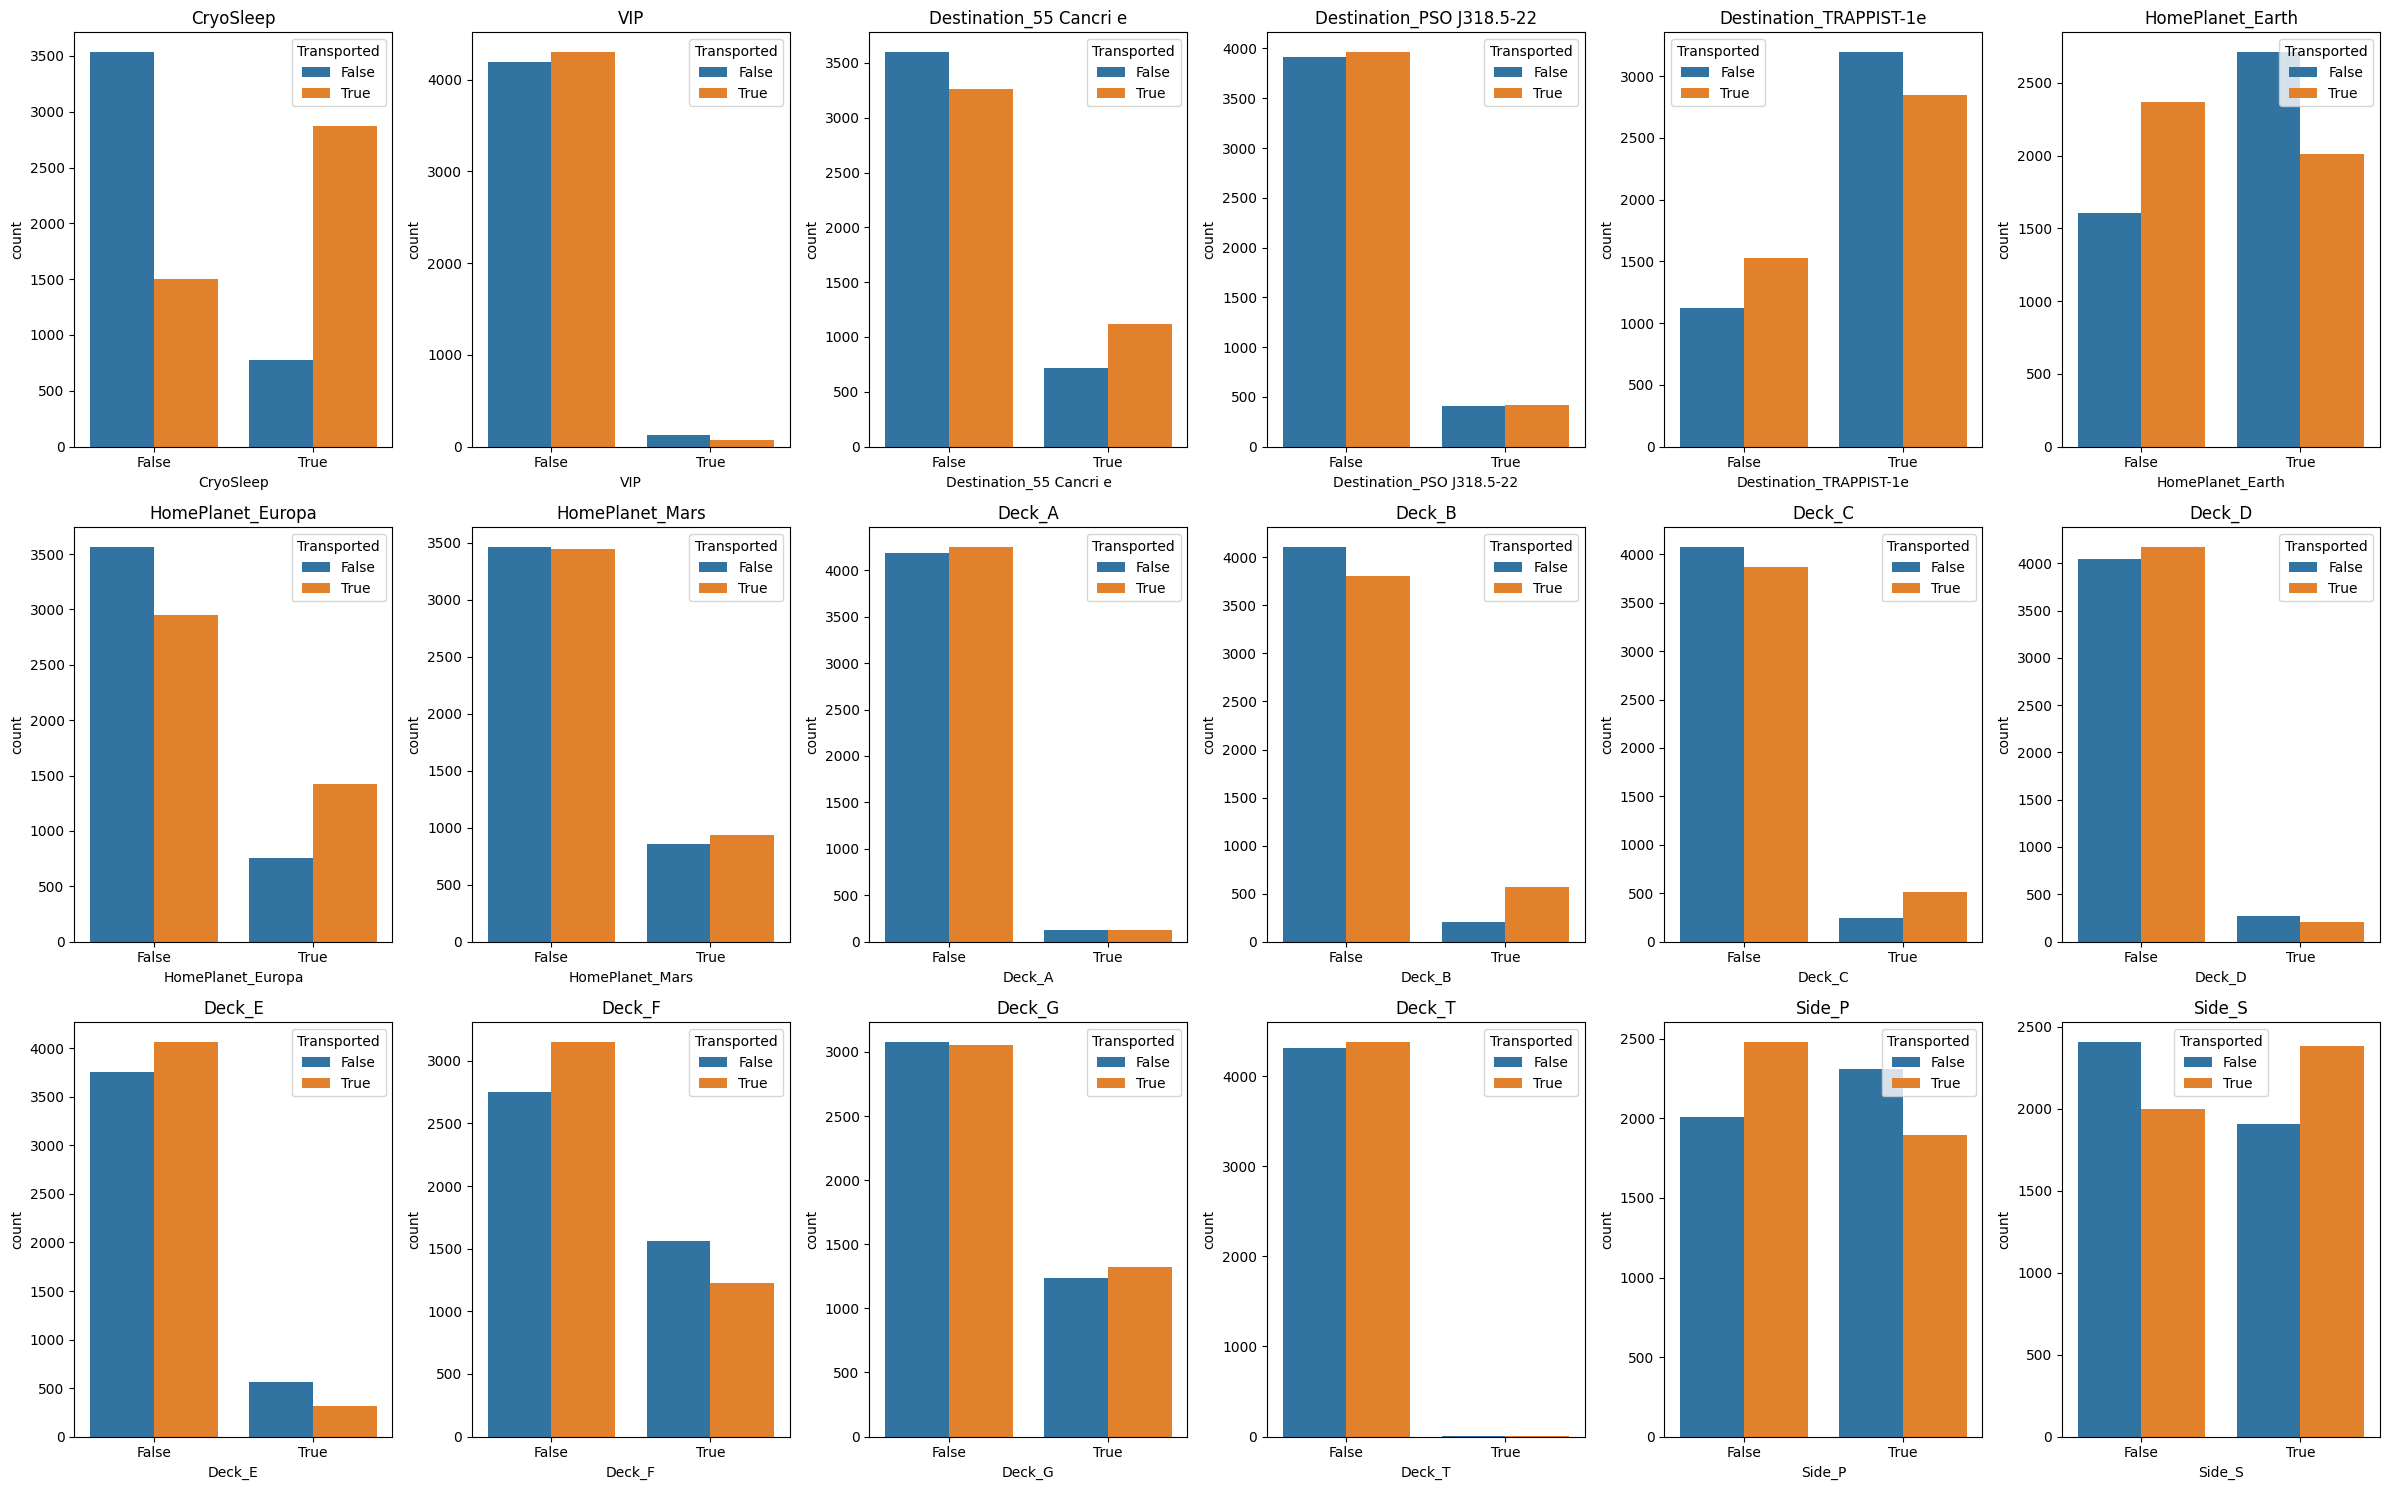

In [22]:
cols_to_investigate = [
    'CryoSleep',
    'VIP',
    'Destination_55 Cancri e',
    'Destination_PSO J318.5-22',
    'Destination_TRAPPIST-1e',
    'HomePlanet_Earth',
    'HomePlanet_Europa',
    'HomePlanet_Mars',
    'Deck_A',
    'Deck_B',
    'Deck_C',
    'Deck_D',
    'Deck_E',
    'Deck_F',
    'Deck_G',
    'Deck_T',
    'Side_P',
    'Side_S'
]

# 2 row, 4 columns, large figure size
fig, axes = plt.subplots(3, 6, figsize=(24, 15))

# Flatten the axes so that we can iterate over them
axes = axes.flatten()

# Plot the data for this category
for i, col in enumerate(cols_to_investigate):
    sns.countplot(x=col, hue='Transported', data=cleaned_train_df, ax=axes[i]);
    axes[i].set_title(col)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
cleaned_train_df.corr()['Transported'].sort_values(ascending=False)

Transported                  1.000000
CryoSleep                    0.481628
HomePlanet_Europa            0.175508
Deck_B                       0.144733
Destination_55 Cancri e      0.109341
Deck_C                       0.108193
Side_S                       0.101455
FoodCourt                    0.045583
HomePlanet_Mars              0.020207
Deck_G                       0.016269
ShoppingMall                 0.009391
Destination_PSO J318.5-22    0.001604
Deck_A                      -0.002623
Deck_T                      -0.014568
Deck_D                      -0.034046
VIP                         -0.037261
Room                        -0.043830
Age                         -0.072606
Deck_F                      -0.087753
Destination_TRAPPIST-1e     -0.097896
Deck_E                      -0.097965
Side_P                      -0.101397
HomePlanet_Earth            -0.169109
VRDeck                      -0.204874
Spa                         -0.218545
RoomService                 -0.241124
Name: Transp

In [24]:
# Ok, let's split the data but ensure we have a stratified split.
X = cleaned_train_df.drop(columns=['Transported'])
y = cleaned_train_df['Transported']

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [25]:
# # Let's try using a RandomForestClassifier with a GridSearchCV to find the best hyperparameters.
# clf = RandomForestClassifier(random_state=42)

# param_grid = {
#     'max_depth': [None, 5, 10, 13, 31, 41, 67],
#     'max_features': [5, 7, 13, 25],
#     'min_samples_leaf': [1, 3, 4, 5],
#     'min_samples_split': [2, 5, 8, 10, 12],
#     'n_estimators': [100, 200, 300, 500, 1000]
# }

# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

In [26]:
# grid_search.fit(X_train, y_train)

In [27]:
# grid_search.best_estimator_

In [28]:
# grid_search.best_score_

In [29]:
xgbclf = XGBClassifier(random_state=42)

xgb_param_grid = {
    'objective': ['binary:logitraw', 'binary:hinge', 'binary:logistic', 'reg:logistic'],
    'max_depth': [None, 3, 5, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [None, 0.1, 0.01, 0.05, 0.10]
}

xgb_grid_search = GridSearchCV(estimator=xgbclf, param_grid=xgb_param_grid, cv=3, n_jobs=-1, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

print(xgb_grid_search.best_score_)
xgb_grid_search.best_estimator_

0.8054357204486626


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [50]:
xgb_grid_search.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 150,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [39]:
train_predictions = xgb_grid_search.best_estimator_.predict(X_train)
test_predictions = xgb_grid_search.best_estimator_.predict(X_test)

print("Accuracy on train:", accuracy_score(y_train, train_predictions))
print("Accuracy on test:", accuracy_score(y_test, test_predictions))

Accuracy on train: 0.8403796376186368
Accuracy on test: 0.8200115008625647


In [51]:
full_trained_estimator = xgb_grid_search.best_estimator_.fit(X, y)
full_predictions = full_trained_estimator.predict(X)

print("Accuracy on fullset:", accuracy_score(y, full_predictions))

Accuracy on fullset: 0.8436673185321523


In [52]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [53]:
cleaned_test_df = pipeline.transform(test_df)

In [57]:
predictions = full_trained_estimator.predict(cleaned_test_df)

In [58]:
predictions = ["True" if x else "False" for x in predictions]

final_df = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': predictions})
final_df.to_csv('submission.csv', index=False)